In [2]:
# OSP (Oversampled Sensor Placement) for a 2-D Vortex Merger
# -----------------------------------------------------------
# This single script:
#   1) Generates a 2-D vortex merger dataset by solving the incompressible
#      Navier–Stokes equations in vorticity–streamfunction form on a periodic domain.
#   2) Stacks snapshots into a matrix and computes a POD (SVD) basis.
#   3) Selects oversampled point sensors via QR pivoting (OSP).
#   4) Reconstructs snapshots from those sensors via least squares.
#   5) Produces pedagogy-friendly plots and summary matrices.
#
# Dependencies: numpy, scipy, matplotlib
# (Install via: pip install numpy scipy matplotlib)
#
# Notes:
# - The pseudo-spectral solver is educational and stable for modest grid sizes (e.g., N=128)
#   and short horizons. Adjust dt/nu for stability.
# - For clarity, de-aliasing uses the 2/3 rule.
# - For pedagogy, we keep the code readable over hyper-optimized.

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftfreq
from scipy.linalg import qr
from numpy.linalg import svd

# --------------------------------------
# 1) 2-D vortex merger data generation
# --------------------------------------

def make_wavenumbers(N, L):
    """Return angular wavenumbers kx, ky (shape (N,N)) and squared magnitude K2.
    Domain is [0, L] x [0, L] with periodic BCs.
    """
    d = L / N
    k1 = 2*np.pi * fftfreq(N, d=d)  # angular wavenumbers
    kx, ky = np.meshgrid(k1, k1, indexing='ij')
    K2 = kx**2 + ky**2
    return kx, ky, K2


def dealias_mask(N, L):
    """2/3-rule de-aliasing mask in Fourier space.
    Keeps modes with |k| <= k_cut in each direction.
    """
    d = L / N
    k1 = 2*np.pi * fftfreq(N, d=d)
    k_cut = (N//3) * (2*np.pi / L)  # angular cutoff
    kx, ky = np.meshgrid(k1, k1, indexing='ij')
    mask = (np.abs(kx) <= k_cut) & (np.abs(ky) <= k_cut)
    return mask


def initial_vorticity_two_gaussians(N, L, centers, strengths, radii):
    """Construct initial vorticity as sum of Lamb–Oseen-like Gaussians.
    centers: [(x1,y1), (x2,y2), ...]
    strengths: [Gamma1, Gamma2, ...] (signed)
    radii: [r1, r2, ...]
    """
    x = np.linspace(0, L, N, endpoint=False)
    y = np.linspace(0, L, N, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing='ij')
    w = np.zeros((N, N))
    for (xc, yc), G, r in zip(centers, strengths, radii):
        dx = np.remainder(X - xc + L/2, L) - L/2  # periodic distance
        dy = np.remainder(Y - yc + L/2, L) - L/2
        w += (G / (np.pi * r**2)) * np.exp(-(dx**2 + dy**2)/r**2)
    return w


def compute_streamfunction_from_vorticity(w, K2):
    """Solve Poisson: ∇² ψ = -ω (periodic) in Fourier space."""
    w_hat = fft2(w)
    psi_hat = np.zeros_like(w_hat, dtype=complex)
    # Avoid division by zero at (0,0); set mean(psi)=0
    with np.errstate(divide='ignore', invalid='ignore'):
        psi_hat = -w_hat / K2
        psi_hat[0, 0] = 0.0
    psi = ifft2(psi_hat).real
    return psi, w_hat, psi_hat


def rhs_vorticity(w, kx, ky, K2, nu, mask):
    """Compute RHS for ω_t = -u·∇ω + ν ∇² ω using pseudo-spectral ops and 2/3 dealiasing."""
    # FFT of vorticity
    w_hat = fft2(w)

    # Streamfunction and velocity in Fourier space
    psi_hat = np.zeros_like(w_hat, dtype=complex)
    with np.errstate(divide='ignore', invalid='ignore'):
        psi_hat = -w_hat / K2
        psi_hat[0, 0] = 0.0

    ux_hat =  1j * ky * psi_hat
    uy_hat = -1j * kx * psi_hat

    ux = ifft2(ux_hat).real
    uy = ifft2(uy_hat).real

    # Gradients of omega in physical space via spectral differentiation
    wx_hat = 1j * kx * w_hat
    wy_hat = 1j * ky * w_hat
    wx = ifft2(wx_hat).real
    wy = ifft2(wy_hat).real

    # Nonlinear term u·∇ω in physical space
    conv = ux * wx + uy * wy

    # Dealias the nonlinear term
    conv_hat = fft2(conv)
    conv_hat *= mask
    conv = ifft2(conv_hat).real

    # Diffusion term ν ∇² ω via spectral Laplacian
    lapw = ifft2(-K2 * w_hat).real

    return -conv + nu * lapw


def simulate_vortex_merger(
    N=128,
    L=2*np.pi,
    T=2.0,
    dt=5e-4,
    nu=1e-3,
    save_every=20,
    centers=((0.35*2*np.pi, np.pi), (0.65*2*np.pi, np.pi)),
    strengths=(10.0, 10.0),
    radii=(0.20, 0.20),
    verbose=True,
):
    """Simulate 2-D vortex merger and return snapshots (N,N,M) and time vector t[M].
    Periodic box. RK4 time stepping. Adjust dt/nu for stability.
    """
    kx, ky, K2 = make_wavenumbers(N, L)
    mask = dealias_mask(N, L)

    w = initial_vorticity_two_gaussians(N, L, centers, strengths, radii)

    nsteps = int(np.round(T/dt))
    times = []
    snaps = []

    for n in range(nsteps+1):
        if n % save_every == 0:
            snaps.append(w.copy())
            times.append(n*dt)
            if verbose and n % (100*save_every) == 0:
                print(f"Saving snapshot at step {n}/{nsteps} (t={n*dt:.3f})")
        if n == nsteps:
            break

        # RK4
        k1 = rhs_vorticity(w, kx, ky, K2, nu, mask)
        k2 = rhs_vorticity(w + 0.5*dt*k1, kx, ky, K2, nu, mask)
        k3 = rhs_vorticity(w + 0.5*dt*k2, kx, ky, K2, nu, mask)
        k4 = rhs_vorticity(w + dt*k3, kx, ky, K2, nu, mask)
        w = w + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    snaps = np.stack(snaps, axis=2)  # (N,N,M)
    times = np.array(times)
    return snaps, times, (kx, ky, K2)


# --------------------------------------
# 2) POD (SVD) and rank selection
# --------------------------------------

def compute_pod(X, energy_thresh=0.99):
    """Compute POD basis from snapshot matrix X (n x m). Returns Psi_r, s, energy, cumE, r."""
    U, s, Vt = svd(X, full_matrices=False)
    energy = (s**2) / np.sum(s**2)
    cumE = np.cumsum(energy)
    r = int(np.searchsorted(cumE, energy_thresh) + 1)
    Psi_r = U[:, :r]
    return Psi_r, s, energy, cumE, r


# --------------------------------------
# 3) Oversampled Sensor Placement (OSP)
# --------------------------------------

def osp_select(Psi_r, p, method="gram"):
    """Return sensor indices via QR pivoting.
    method="gram": QR on G = Psi_r @ Psi_r.T (recommended for p>r)
    method="qdeim": QR on Psi_r.T (use when p==r)
    """
    if method == "qdeim":
        _, _, piv = qr(Psi_r.T, pivoting=True)
        idx = piv[:p]
        return np.array(idx, dtype=int)
    elif method == "gram":
        G = Psi_r @ Psi_r.T
        _, _, piv = qr(G, pivoting=True)
        idx = piv[:p]
        return np.array(idx, dtype=int)
    else:
        raise ValueError("Unknown method. Use 'gram' or 'qdeim'.")


# --------------------------------------
# 4) Reconstruction from point sensors
# --------------------------------------

def reconstruct_from_sensors(Psi_r, X, idx, lam=0.0):
    """Reconstruct columns of X using sensors at idx and POD basis Psi_r.
    X: (n x m) snapshot matrix, n=N*N.
    Returns Xhat (n x m), Theta, and precomputed solver pieces.
    """
    Theta = Psi_r[idx, :]  # (p, r)
    r = Psi_r.shape[1]
    A = Theta.T @ Theta + lam*np.eye(r)
    Ainv_ThetaT = np.linalg.solve(A, Theta.T)

    # Measure and reconstruct each column
    def recon_col(x):
        y = x[idx]
        a_hat = Ainv_ThetaT @ y
        return Psi_r @ a_hat

    Xhat = np.column_stack([recon_col(X[:, k]) for k in range(X.shape[1])])
    return Xhat, Theta, Ainv_ThetaT


# --------------------------------------
# 5) Diagnostics & pedagogy plots
# --------------------------------------

def condition_number(Theta):
    s = np.linalg.svd(Theta, compute_uv=False)
    return float(s[0]/s[-1])


def logdet_ThetaTTheta(Theta):
    # Use SVD for numerical stability: ΘᵀΘ has eigenvalues s_i^2
    s = np.linalg.svd(Theta, compute_uv=False)
    vals = s**2
    # Avoid log(0) if rank-deficient
    vals = np.clip(vals, 1e-300, None)
    return float(np.sum(np.log(vals)))


def plot_singular_values(s):
    plt.figure()
    plt.semilogy(s, marker='o', linewidth=1)
    plt.xlabel('Mode index')
    plt.ylabel('Singular value σ')
    plt.title('Singular value spectrum')
    plt.tight_layout()


def plot_cumulative_energy(cumE):
    plt.figure()
    plt.plot(cumE, linewidth=1)
    plt.axhline(0.99, linestyle='--')
    plt.ylim(0, 1.05)
    plt.xlabel('Mode index r')
    plt.ylabel('Cumulative energy')
    plt.title('Cumulative energy vs r')
    plt.tight_layout()


def plot_modes(Psi_r, N, num=3):
    plt.figure(figsize=(12, 3))
    for i in range(min(num, Psi_r.shape[1])):
        plt.subplot(1, num, i+1)
        plt.imshow(Psi_r[:, i].reshape(N, N).T, origin='lower', aspect='equal')
        plt.title(f'Mode {i+1}')
        plt.axis('off')
    plt.suptitle('Leading POD modes (vorticity)')
    plt.tight_layout(rect=[0, 0, 1, 0.95])


def plot_sensor_overlay(field2d, idx, N, title='Sensor locations over vorticity'):
    plt.figure()
    plt.contourf(field2d.T, levels=50)
    yy, xx = np.unravel_index(idx, (N, N))
    plt.scatter(xx, yy, s=25, edgecolor='k', facecolor='w')
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()


def plot_conditioning_vs_p(Psi_r, N, p_values, trials_random=20):
    cn_osp = []
    cn_rand_med = []
    cn_rand_iqr = []
    for p in p_values:
        # OSP
        idx = osp_select(Psi_r, p, method='gram' if p>Psi_r.shape[1] else 'qdeim')
        Theta = Psi_r[idx, :]
        cn_osp.append(condition_number(Theta))
        # Random
        rnd = []
        for _ in range(trials_random):
            idx_r = np.random.choice(N*N, size=p, replace=False)
            Theta_r = Psi_r[idx_r, :]
            s = np.linalg.svd(Theta_r, compute_uv=False)
            if s[-1] <= 1e-14:
                rnd.append(np.inf)
            else:
                rnd.append(float(s[0]/s[-1]))
        rnd = np.array(rnd)
        cn_rand_med.append(np.median(rnd))
        # IQR
        q25, q75 = np.nanpercentile(rnd, [25, 75])
        cn_rand_iqr.append((q25, q75))
    # Plot
    plt.figure()
    plt.plot(p_values, cn_osp, marker='o', label='OSP')
    med = np.array(cn_rand_med)
    iqr = np.array(cn_rand_iqr)
    plt.plot(p_values, med, marker='s', label='Random (median)')
    plt.fill_between(p_values, iqr[:,0], iqr[:,1], alpha=0.25, label='Random IQR')
    plt.xlabel('Number of sensors p')
    plt.ylabel('cond(Θ)')
    plt.yscale('log')
    plt.title('Condition number vs number of sensors')
    plt.legend()
    plt.tight_layout()


def plot_logdet_vs_p(Psi_r, p_values):
    vals = []
    for p in p_values:
        idx = osp_select(Psi_r, p, method='gram' if p>Psi_r.shape[1] else 'qdeim')
        Theta = Psi_r[idx, :]
        vals.append(logdet_ThetaTTheta(Theta))
    plt.figure()
    plt.plot(p_values, vals, marker='o')
    plt.xlabel('Number of sensors p')
    plt.ylabel('log det(ΘᵀΘ)')
    plt.title('D-optimal volume growth vs p (OSP)')
    plt.tight_layout()


def plot_row_leverage(Psi_r, N):
    lev = np.linalg.norm(Psi_r, axis=1)  # row 2-norms
    plt.figure()
    plt.imshow(lev.reshape(N, N).T, origin='lower', aspect='equal')
    plt.colorbar(label='Row leverage ∥Ψ_r[i,:]∥₂')
    plt.title('Row leverage heatmap')
    plt.axis('off')
    plt.tight_layout()


def plot_error_timeseries(times, X, Xhat):
    # Relative L2 error per snapshot
    num = X.shape[1]
    errs = np.linalg.norm(X - Xhat, axis=0) / np.linalg.norm(X, axis=0)
    plt.figure()
    plt.plot(times[:num], errs, marker='.')
    plt.xlabel('Time')
    plt.ylabel('Relative L2 error')
    plt.title('Reconstruction error over time')
    plt.tight_layout()


def plot_spatial_error(X, Xhat, N, k, title='Spatial absolute error |ω - ω̂|'):
    e = np.abs((X[:, k] - Xhat[:, k]).reshape(N, N))
    plt.figure()
    plt.imshow(e.T, origin='lower', aspect='equal')
    plt.colorbar(label='|error|')
    plt.title(f'{title} (snapshot {k})')
    plt.axis('off')
    plt.tight_layout()


def enstrophy(field):
    # Z = 0.5 * ||ω||_2^2
    return 0.5 * np.sum(field**2)


def plot_enstrophy(times, snaps, snaps_hat):
    Z_true = [enstrophy(snaps[:, :, i]) for i in range(snaps.shape[2])]
    Z_hat  = [enstrophy(snaps_hat[:, :, i]) for i in range(snaps_hat.shape[2])]
    plt.figure()
    plt.plot(times, Z_true, label='True')
    plt.plot(times, Z_hat, label='Reconstructed', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Enstrophy')
    plt.title('Enstrophy over time: truth vs reconstruction')
    plt.legend()
    plt.tight_layout()



In [3]:
# ---- Parameters (tweak as needed) ----
N = 128             # grid size per dimension
L = 2*np.pi         # box length (periodic)
T = 2.0             # simulation horizon
dt = 5e-4           # time step (smaller -> more stable)
nu = 1e-3           # viscosity
save_every = 20     # save one snapshot every this many steps

# Initial vortex pair (same sign) — likely merger
centers = ((0.35*L, 0.5*L), (0.65*L, 0.5*L))
strengths = (10.0, 10.0)
radii = (0.20, 0.20)

# POD/OSP settings
energy_thresh = 0.99
oversample_factor = 2.0   # p = oversample_factor * r
lam = 0.0                 # Tikhonov regularization (0 for LS)



In [4]:
# ---- 1) Simulate and collect snapshots ----
snaps, times, (kx, ky, K2) = simulate_vortex_merger(
    N=N, L=L, T=T, dt=dt, nu=nu, save_every=save_every,
    centers=centers, strengths=strengths, radii=radii, verbose=True)
M = snaps.shape[2]
print(f"Generated {M} snapshots on a {N}x{N} grid (vectorized n={N*N}).")



Saving snapshot at step 0/4000 (t=0.000)
Saving snapshot at step 2000/4000 (t=1.000)
Saving snapshot at step 4000/4000 (t=2.000)
Generated 201 snapshots on a 128x128 grid (vectorized n=16384).


In [5]:
# Stack snapshots into X (n x m)
X = snaps.reshape(N*N, M)

# ---- 2) POD basis ----
Psi_r, s, energy, cumE, r = compute_pod(X, energy_thresh=energy_thresh)
print(f"Selected rank r={r} for {energy_thresh*100:.1f}% energy capture (m={M}).")



Selected rank r=6 for 99.0% energy capture (m=201).


In [6]:
# ---- 3) OSP sensor selection ----
p = int(np.ceil(oversample_factor * r))
method = 'gram' if p > r else 'qdeim'
idx = osp_select(Psi_r, p, method=method)
print(f"Selected p={p} sensors via OSP ({method}).")



Selected p=12 sensors via OSP (gram).


In [7]:
# ---- 4) Reconstruct the (same) snapshots from selected sensors ----
Xhat, Theta, _ = reconstruct_from_sensors(Psi_r, X, idx, lam=lam)

# ---- Diagnostics ----
cn = condition_number(Theta)
ld = logdet_ThetaTTheta(Theta)
rel_err = np.linalg.norm(X - Xhat, axis=0) / np.linalg.norm(X, axis=0)
print(f"cond(Θ)={cn:.2e},  log det(ΘᵀΘ)={ld:.2f}")
print(f"Median relative L2 error across snapshots: {np.median(rel_err):.3e}")



cond(Θ)=1.35e+00,  log det(ΘᵀΘ)=-19.74
Median relative L2 error across snapshots: 9.643e-02


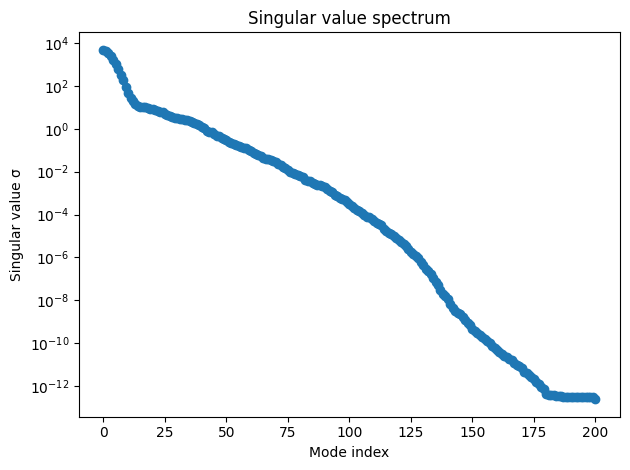

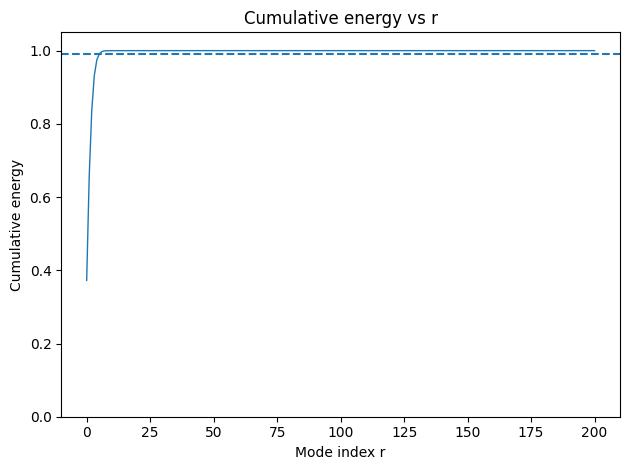

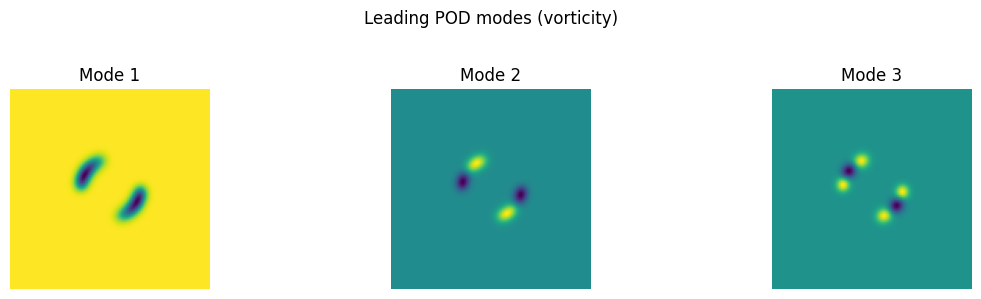

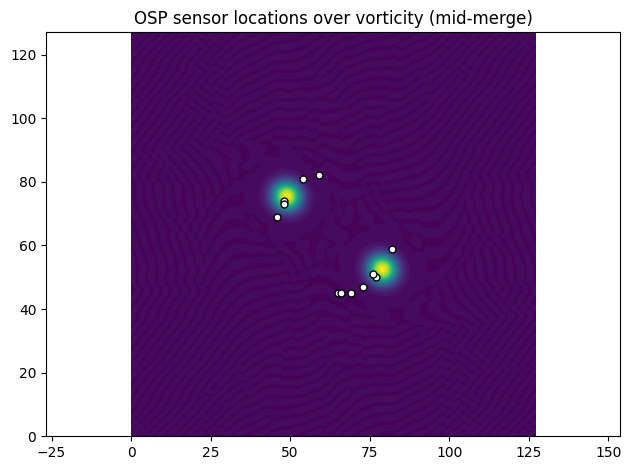

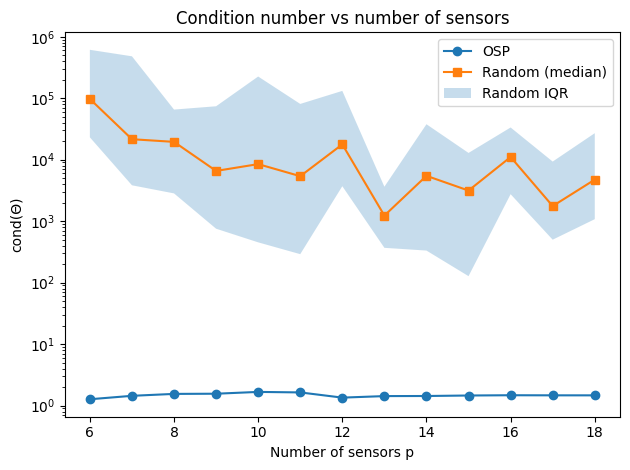

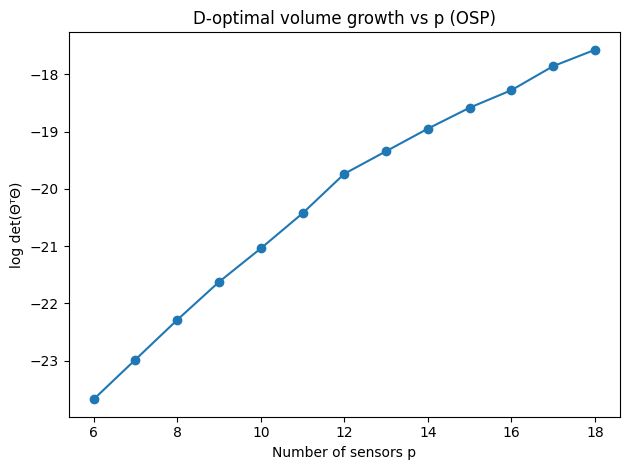

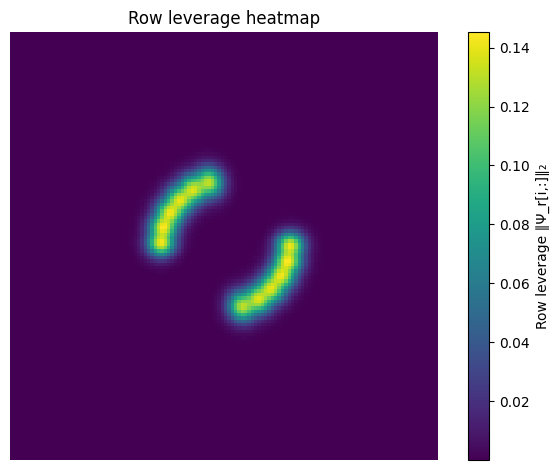

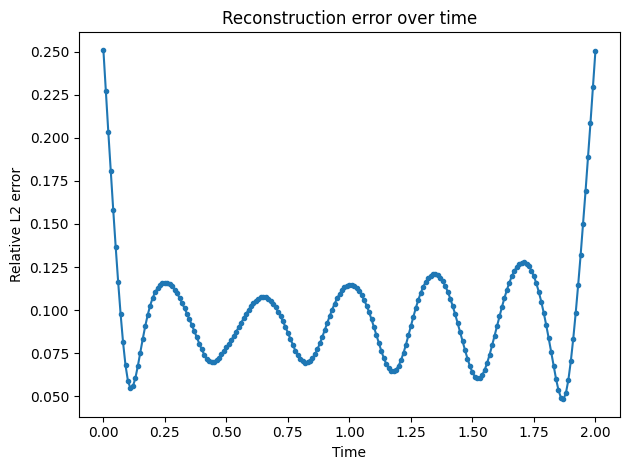

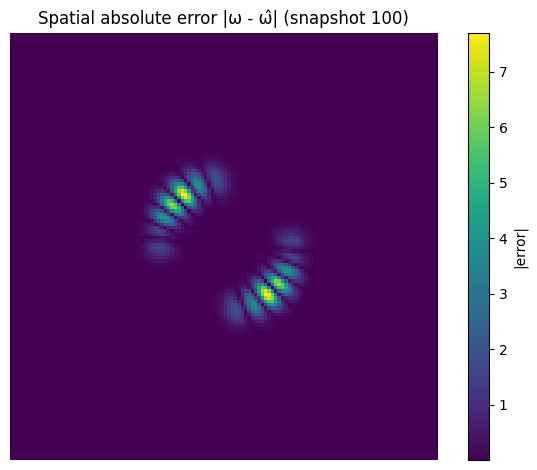

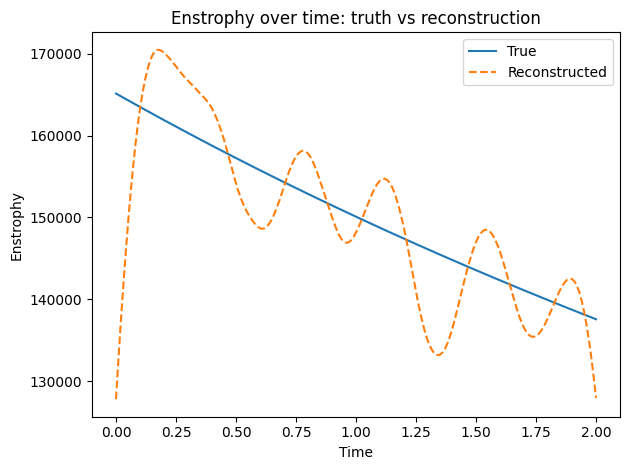

In [8]:
# ---- 5) Pedagogical plots ----
# (A) SVD diagnostics
plot_singular_values(s)
plot_cumulative_energy(cumE)
plt.show()
# (B) POD modes
plot_modes(Psi_r, N, num=min(3, r))
plt.show()
# (C) Sensor overlay on a representative snapshot
k_show = M//2
plot_sensor_overlay(snaps[:, :, k_show], idx, N, title='OSP sensor locations over vorticity (mid-merge)')
plt.show()
# (D) Conditioning vs p and D-optimal metric vs p
p_values = list(range(max(4, r), min(N*N-1, int(3*r))+1, max(1, r//5)))
plot_conditioning_vs_p(Psi_r, N, p_values, trials_random=20)
plot_logdet_vs_p(Psi_r, p_values)
plt.show()
# (E) Row leverage heatmap
plot_row_leverage(Psi_r, N)
plt.show()
# (F) Error timeseries and spatial error map
Xhat_snaps = Xhat.reshape(N, N, M)
plot_error_timeseries(times, X, Xhat)
plot_spatial_error(X, Xhat, N, k_show)
plt.show()
# (G) Enstrophy comparison
plot_enstrophy(times, snaps, Xhat_snaps)

plt.show()
